In [1]:
import numpy as np
import os
import pyarrow
import sys
import json
import math
import mpl_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET

import pandas as pd
import polars as pl


# Directories

In [2]:
sys.path.append("../functions")
import Demand_functions as dmd

In [3]:
# General directories
general_directory = '/Users/andre/Desktop/Cergy/'

berlin_directory = 'MATSim/matsim-berlin/input/v6.4/'

run_dir = "Python_Scripts/runs/"

In [4]:
# metro
METRO_INPUT = (os.path.join(general_directory, run_dir, "pt_10pct/metro_inputs/"))

METRO_OUTPUT = (os.path.join(general_directory, run_dir, "pt_10pct/metro_outputs/"))

EVENTS_PATH = ((os.path.join(general_directory, berlin_directory, "parquet/")))

# Path to MATSim's experienced plans.
PLAN_PATH = "/Users/andre/Desktop/Cergy/Python_Scripts/runs/fixed_10pct/matsim/"

# Path to the directory where the Metropolis output is stored.
#MATSIM_TRIPS = (os.path.join(general_directory, run_dir, "avg_10runs/metro_outputs/"))


# Read Plans

In [5]:
def read_matsim_plans():
    persons = pl.read_parquet(os.path.join(PLAN_PATH, 'MATSim_persons.parquet'))
    plans = pl.read_parquet(os.path.join(PLAN_PATH, 'MATSim_plans.parquet'))
    activities = pl.read_parquet(os.path.join(PLAN_PATH, 'MATSim_activities.parquet'))
    legs = pl.read_parquet(os.path.join(PLAN_PATH, 'MATSim_legs.parquet'))
    routes = pl.read_parquet(os.path.join(PLAN_PATH, 'MATSim_routes.parquet'))

    return persons, plans, activities, legs, routes

In [6]:
def read_metropolis_results():
    agents = pl.read_parquet(os.path.join(METRO_OUTPUT, "agent_results.parquet"))
    trips = pl.read_parquet(os.path.join(METRO_OUTPUT, "trip_results.parquet"))
    routes = pl.read_parquet(os.path.join(METRO_OUTPUT, "route_results.parquet"))
    return agents, trips, routes

In [7]:
trip_inputs = pl.read_parquet(os.path.join(METRO_INPUT, "trips.parquet"))

In [8]:
print("Reading MATSim experienced plans")
persons, plans, activities, legs, routes = read_matsim_plans()

print("Reading METROPOLIS results")
mp_agents, mp_trips, mp_routes = read_metropolis_results()

Reading MATSim experienced plans
Reading METROPOLIS results


In [9]:
matsim_trips = pl.read_parquet(os.path.join(general_directory, run_dir, 'pt_10pct/matsim_trips/MATSim_trips.parquet'))

In [10]:
matsim_trips = (
    matsim_trips
    .with_columns([((pl.col("plan_id")*100).cast(pl.Utf8)+ pl.col("tour_id").cast(pl.Utf8))
                                          .cast(pl.Int64).alias("agent_id")]) # agent_id ={plan_id*100;tour_id}
    .join(trip_inputs.select(['agent_id', 'alt_id', 'trip_id', 'stopping_time']), on=['agent_id', 'trip_id'])
    .drop(['start_time_secs', 'is_tour_anchor', 'end_time_secs', 'type_or_mode', 
                                  'element_type', 'seq_index_right'])
    .join(plans.select(['person_id', 'score']), on='person_id')
    
)

In [11]:
legs = legs.join(routes, left_on='id', right_on='leg_id').rename({'value':'route'})
matsim_car_trips = (
    matsim_trips
    .with_columns([(((pl.col("plan_id")*100).cast(pl.Utf8))+((pl.col("tour_id")).cast(pl.Utf8)))
                                           .cast(pl.Int64).alias("agent_id")])
    .join(legs.select(['plan_id', 'mode', 'distance', 'route', 'start_link', 'end_link']), 
          on = ['plan_id', 'mode', 'route', 'start_link', 'end_link'])
    .filter(pl.col('mode').is_in(['car', 'freight', 'truck', 'ride']))
    .sort(["agent_id"])
    .drop('start_link', 'end_link')

)

# Route Comparison

In [12]:
route_comparison = (
    mp_trips
    .select(['agent_id', 'trip_id', 'length'])
    .join(matsim_car_trips.select(['agent_id', 'trip_id', 'distance']), on=['agent_id', 'trip_id'])
    .with_columns(pl.col('distance').cast(pl.Float64))

)

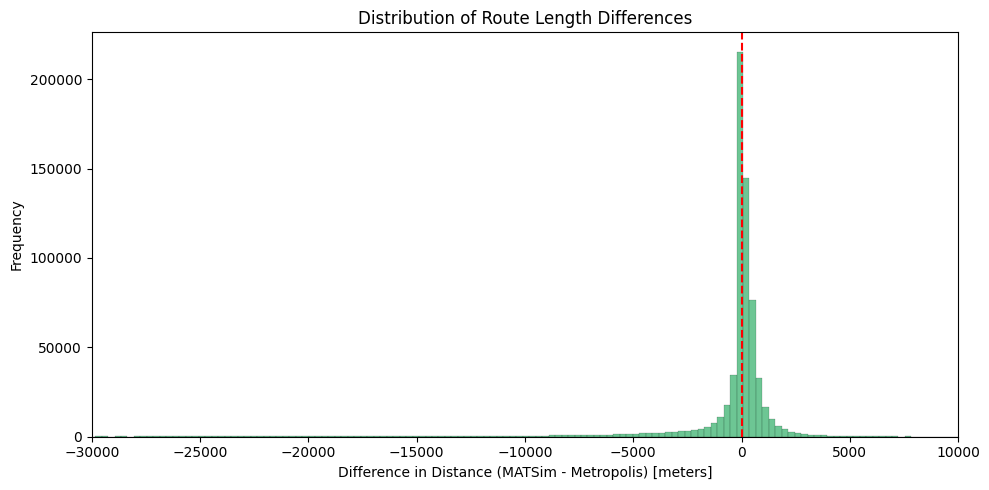

In [13]:
# Convertir a pandas si es necesario
df_pd = route_comparison.to_pandas()

# Crear la variable diferencia
df_pd["dist_diff"] = df_pd["distance"] - df_pd["length"]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(df_pd["dist_diff"], bins=500, color="mediumseagreen")

# Línea vertical en 0
plt.axvline(0, color="red", linestyle="--")

plt.xlim(-30000, 10000)  # Limita el eje x a entre -1000 y 1000 metros
# Etiquetas y título
plt.xlabel("Difference in Distance (MATSim - Metropolis) [meters]")
plt.ylabel("Frequency")
plt.title("Distribution of Route Length Differences")
plt.tight_layout()
plt.show()

In [14]:
df_pd["dist_diff"].describe()

count    668887.000000
mean       -903.507077
std        4841.033936
min      -93886.950000
25%        -134.305000
50%           9.630000
75%         350.920000
max       55722.700000
Name: dist_diff, dtype: float64